# CS4487 - Machine Learning
# Lecture 10a - Deep Learning 2
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
- Image Classification and Deep Architectures
- **Unsupervised Learning**

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

rbow = plt.get_cmap('rainbow')

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklear

In [2]:
# use TensorFlow backend
%env KERAS_BACKEND=tensorflow     
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, \
                Input, MaxPooling2D, UpSampling2D, Lambda, Reshape, BatchNormalization, \
                GlobalAveragePooling2D
import keras
import tensorflow
import logging
logging.basicConfig()
import struct

# use channels first representation for images
from keras import backend as K
K.set_image_data_format('channels_first')

from keras.callbacks import TensorBoard

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


In [3]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'acc' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['acc'], 'b', label="training acc ({:.4f})".format(history.history['acc'][-1]))
        ax2.plot(history.history['val_acc'], 'b--', label="validation acc ({:.4f})".format(history.history['val_acc'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [4]:
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                plt.title(titles % idx)
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()


In [5]:
def read_32int(f):
    return struct.unpack('>I', f.read(4))[0]
def read_img(img_path):
    with open(img_path, 'rb') as f:
        magic_num = read_32int(f)
        num_image = read_32int(f)
        n_row = read_32int(f)
        n_col = read_32int(f)
        #print 'num_image = {}; n_row = {}; n_col = {}'.format(num_image, n_row, n_col)
        res = []
        npixel = n_row * n_col
        res_arr = fromfile(f, dtype='B')
        res_arr = res_arr.reshape((num_image, n_row, n_col), order='C')
        #print 'image data shape = {}'.format(res_arr.shape)
        return num_image, n_row, n_col, res_arr    
def read_label(label_path):
    with open(label_path, 'rb') as f:
        magic_num = read_32int(f)
        num_label = read_32int(f)
        #print 'num_label = {}'.format(num_label)
        res_arr = fromfile(f, dtype='B')
        #print res_arr.shape
        #res_arr = res_arr.reshape((num_label, 1))
        res_arr = res_arr.ravel()
        #print 'label data shape = {}'.format(res_arr.shape)
        return num_label, res_arr

In [6]:
n_train, nrow, ncol, trainimg = read_img('data/train-images.idx3-ubyte')
_, trainY = read_label('data/train-labels.idx1-ubyte')
n_test, _, _, testimg = read_img('data/t10k-images.idx3-ubyte')
_, testY = read_label('data/t10k-labels.idx1-ubyte')

# for demonstration we only use 10% of the training data
sample_index = range(0, trainimg.shape[0], 10)
trainimg  = trainimg[sample_index]
trainY    = trainY[sample_index]
print(trainimg.shape)
print(trainY.shape)
print(testimg.shape)
print(testY.shape)

(6000, 28, 28)
(6000,)
(10000, 28, 28)
(10000,)


In [7]:
# Reshape the images to a vector
# and map the data to [0,1]
trainXraw = trainimg.reshape((len(trainimg), -1), order='C') / 255.0
testXraw = testimg.reshape((len(testimg), -1), order='C') / 255.0

# center the image data (but don't change variance)
scaler = preprocessing.StandardScaler(with_std=False)
trainX = scaler.fit_transform(trainXraw)
testX  = scaler.transform(testXraw)

# convert class labels to binary indicators
trainYb = keras.utils.np_utils.to_categorical(trainY)

print(trainX.shape)
print(trainYb.shape)

(6000, 784)
(6000, 10)


In [8]:
# generate a fixed validation set using 10% of the training set
vtrainX, validX, vtrainYb, validYb = \
  model_selection.train_test_split(trainX, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4487)

# validation data
validset  = (validX, validYb)

In [9]:
# scale to 0-1
trainI = (trainimg.reshape((6000,1,28,28)) / 255.0)
testI  = (testimg.reshape((10000,1,28,28)) / 255.0)
print(trainI.shape)
print(testI.shape)

(6000, 1, 28, 28)
(10000, 1, 28, 28)


In [10]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4487)

validsetI = (validI, validYb)

# Neural Networks and Unsupervised Learning
- How to use NN for dimensionality reduction or clustering?


# Denoising Autoencoder
- Use the hidden layer as the lower-dimensional representation (code)
- Train the network to "encode" and "decode"
  - randomly corrupt the input (by setting values to 0)
  - run it through the encoding-decoding network
  - minimize the difference between the output and the original input
<center><img src="imgs/ae.png" width=400></center>

# Example on MNIST
- Reshape the images into vectors, and scale to [0,1]

In [11]:
# Reshape the images and map the data to [0,1]
trainXraw = trainimg.reshape((len(trainimg), -1), order='C') / 255.0
testXraw = testimg.reshape((len(testimg), -1), order='C') / 255.0

In [12]:
# generate a fixed validation set using 10% of the training set
vtrainXraw, validXraw = \
  model_selection.train_test_split(trainXraw, 
  train_size=0.9, test_size=0.1, random_state=4487)

- Train the autoencoder
  - specify the number of hidden nodes
  - corrupt the image using Dropout
    - corruption level = percentage of inputs that are zeroed out.

- Use `Model` class.
  - pass input and output layers. 
  - The model consists of everything between input and output.

In [13]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# Build the Encoder model
input_img = Input(shape=(784,))
corrupted_img = Dropout(rate=0.3)(input_img)
encoded = Dense(10, activation='relu')(corrupted_img)
encoder = Model(input_img, encoded)

# Build the Decoder model
encoded_input = Input(shape=(10,))
decoded = Dense(784, activation='sigmoid')(encoded_input)
decoder = Model(encoded_input, decoded)

# build the full autoencoder model
autoencoder = Model(input_img, decoder(encoder(input_img)))

- Encoder and decoder subnetworks

In [14]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [15]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               8624      
Total params: 8,624
Trainable params: 8,624
Non-trainable params: 0
_________________________________________________________________


- Full auto-encoder network
  - Composed of the encoder and decoder models

In [16]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
model_1 (Model)              (None, 10)                7850      
_________________________________________________________________
model_2 (Model)              (None, 784)               8624      
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


- Compile the model

In [17]:
# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                            min_delta=0.0001, patience=10,
                            verbose=1, mode='auto')
                
# compile and fit the network
autoencoder.compile(loss=keras.losses.binary_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.2, momentum=0.9, nesterov=True))

- Fit the model

In [20]:
sess = tensorflow.Session(config=tensorflow.ConfigProto(log_device_placement=True))

In [18]:
# fit the model: the input and output are the same
# write to a log directory to see training process
history = autoencoder.fit(vtrainXraw, vtrainXraw, 
                 epochs=20, batch_size=50, 
                 callbacks=[earlystop, TensorBoard(log_dir='./logs/ae')],
                 validation_data=(validXraw, validXraw), verbose=False)

InternalError: Blas GEMM launch failed : a.shape=(50, 784), b.shape=(784, 10), m=50, n=10, k=784
	 [[node model_1/dense_1/MatMul (defined at C:\Users\srini\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:1076)  = MatMul[T=DT_FLOAT, _class=["loc:@training/SGD/gradients/model_1/dense_1/MatMul_grad/MatMul_1"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](model_1/dropout_1/cond/Merge, dense_1/kernel/read)]]
	 [[{{node loss/mul/_53}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_394_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'model_1/dense_1/MatMul', defined at:
  File "D:\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "D:\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "D:\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "D:\Anaconda3\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "D:\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "D:\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "D:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "D:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-b26dcc624302>", line 16, in <module>
    autoencoder = Model(input_img, decoder(encoder(input_img)))
  File "C:\Users\srini\AppData\Roaming\Python\Python36\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\srini\AppData\Roaming\Python\Python36\site-packages\keras\engine\topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "C:\Users\srini\AppData\Roaming\Python\Python36\site-packages\keras\engine\topology.py", line 2235, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "C:\Users\srini\AppData\Roaming\Python\Python36\site-packages\keras\layers\core.py", line 877, in call
    output = K.dot(inputs, self.kernel)
  File "C:\Users\srini\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py", line 1076, in dot
    out = tf.matmul(x, y)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2057, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4857, in mat_mul
    name=name)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(50, 784), b.shape=(784, 10), m=50, n=10, k=784
	 [[node model_1/dense_1/MatMul (defined at C:\Users\srini\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:1076)  = MatMul[T=DT_FLOAT, _class=["loc:@training/SGD/gradients/model_1/dense_1/MatMul_grad/MatMul_1"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](model_1/dropout_1/cond/Merge, dense_1/kernel/read)]]
	 [[{{node loss/mul/_53}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_394_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


- Run tensorboard in console: `tensorboard --logdir=./logs.ae`
- View training procedure:  http://0.0.0.0:6006

<center><img src="imgs/tensorboard-eg.png" width=500></center>

- Encode images into low-dim representation.

In [19]:
Z = encoder.predict(trainXraw)
Z.shape

(6000, 10)

- Visualize the nearby neighbors in the low-dim representation.
  - each row represents one set of neighbors

In [20]:
Wlist = []
for ii in [210,4,101,9,294]:
    d = metrics.pairwise.euclidean_distances(Z, [Z[ii]])
    inds = argsort(d.ravel())
    for x in inds[0:10]:
        Wlist.append(trainXraw[x].reshape((28,28)))
        
Zfig = plt.figure()
show_imgs(Wlist)
plt.close()

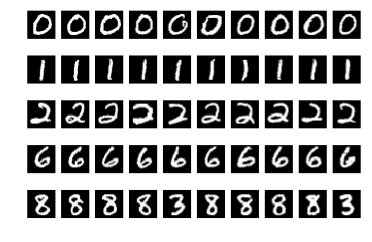

In [21]:
Zfig

- Visualize the weights of the hidden layer that generate codes
  - each hidden node activates on a particular structure

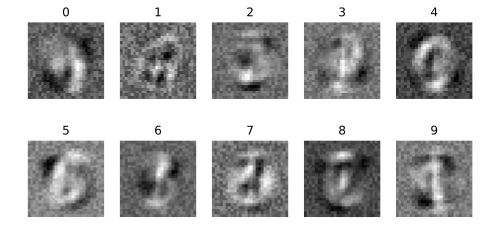

In [22]:
W = encoder.get_layer(index=2).get_weights()[0]
filter_list = [W[:,i].reshape((28,28)) for i in range(W.shape[1])]
plt.figure(figsize=(8,4))
show_imgs(filter_list, nc=5, titles="%d")

- Visualize the weights that project the code into an image
  - the image structures match those of the encoder, but are smoother.

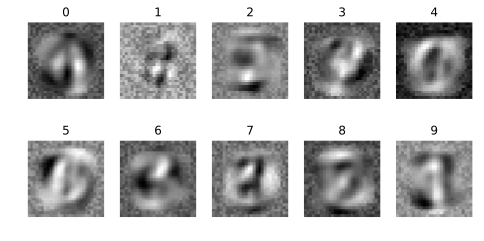

In [23]:
W = decoder.get_layer(index=1).get_weights()[0]
filter_list = [W[i,:].reshape((28,28)) for i in range(W.shape[0])]
plt.figure(figsize=(8,4))
show_imgs(filter_list, nc=5, titles="%d")

- Visualize the reconstruction of the input image

In [24]:
testXrecon = decoder.predict(encoder.predict(testXraw))

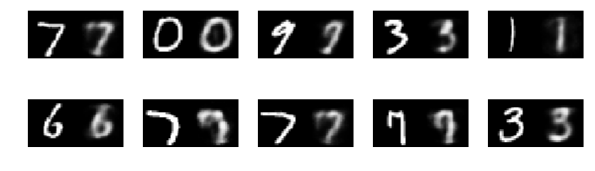

In [25]:
imglist = []
for j,i in enumerate(range(0,100,10)):
    tmp = hstack( (testXraw[i].reshape((28,28)), testXrecon[i].reshape((28,28))) )
    imglist.append(tmp)
rfig = plt.figure(figsize=(10,3))
show_imgs(imglist,nc=5)
plt.close()
rfig

- Corrupt the input image and encode-decode
  - performs "denoising" of the input

In [26]:
noisytest = testXraw * random.binomial(n=1,p=1-0.3,size=testXraw.shape)
testXrecon = decoder.predict(encoder.predict(noisytest))

In [27]:
imglist = []
for j,i in enumerate(range(0,100,10)):
    tmp = hstack( (noisytest[i].reshape((28,28)), testXrecon[i].reshape((28,28))) )
    imglist.append(tmp)
dfig = plt.figure(figsize=(10,3))
show_imgs(imglist,nc=5)
plt.close()

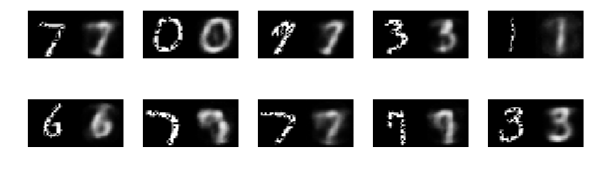

In [28]:
dfig

# Convolutional Auto-Encoder
- Encoder - a standard CNN (w/o classifier)
  - Extract a feature map

In [29]:
random.seed(4487); tensorflow.set_random_seed(4487)

# the Conv2D encoder
input_img2 = Input(shape=(1, 28, 28))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img2)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded2 = MaxPooling2D((2, 2), padding='same')(x)
encoder2 = Model(input_img2, encoded2)
# the representation is (8, 4, 4) i.e. 128-dimensional

- Decoder
  - the opposite architecture
  - Replace maxpooling with upsampling 

In [30]:
# the Conv2D decoder
encoded_input2 = Input(shape=(8,4,4))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_input2)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder2 = Model(encoded_input2, decoded2)

- Connect the two to form the autoencoder

In [31]:
# connect the encoder to the decoder
autoencoder2 = Model(input_img2, decoder2(encoder2(input_img2)))
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy')

- Encoder and Decoders

In [32]:
encoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 28, 28)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 14, 14)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 7, 7)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 7, 7)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 4, 4)           0         
Total para

In [33]:
decoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 8, 4, 4)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 4, 4)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 8, 16, 16)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 14, 14)        1168      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 16, 28, 28)        0         
__________

- The whole autoencoder

In [34]:
autoencoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
model_4 (Model)              (None, 8, 4, 4)           1904      
_________________________________________________________________
model_5 (Model)              (None, 1, 28, 28)         2481      
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


- Now fit the model

In [35]:
# training with images
history = autoencoder2.fit(vtrainI, vtrainI,
                            epochs=50,
                            batch_size=128,
                            shuffle=True,
                            callbacks=[earlystop, TensorBoard(log_dir='./logs/ae2')],
                            validation_data=(validI, validI), verbose=False)

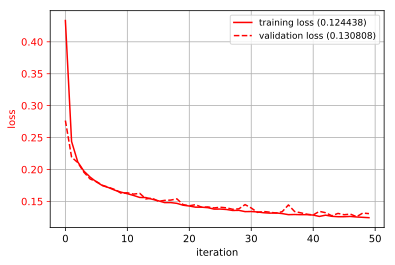

In [36]:
plot_history(history)

- Encode and reconstruct an image

In [37]:
testIrecon = decoder2.predict(encoder2.predict(testI))

- Better visualization

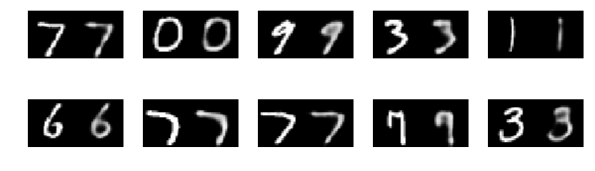

In [38]:
imglist = []
for j,i in enumerate(range(0,100,10)):
    tmp = hstack( (testI[i].reshape((28,28)), testIrecon[i].reshape((28,28))) )
    imglist.append(tmp)
rfig = plt.figure(figsize=(10,3))
show_imgs(imglist,nc=5)
plt.close()
rfig

- Traverse the latent space
- Change a 7 into a 1

In [39]:
def Xinterp(X,sp=10):
    alpha = linspace(0,1,sp).reshape((sp,)+(ndim(X)-1)*(1,))
    Xint = X[0,:]*(1-alpha) + X[1,:]*alpha
    return Xint

In [40]:
inds = [0,40]
X = encoder2.predict(testI[inds,:])
Xd = decoder2.predict(Xinterp(X))

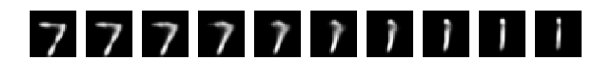

In [41]:
rfig = plt.figure(figsize=(10,3))
show_imgs(Xd.reshape((10,28,28)),nc=10)
plt.close()
rfig

- Traverse the latent space between a 7, 1, 9, and 4
  - captures shapes in between

In [42]:
def Xinterp2(X, sp=10):
    # [TL, TR, BL, BR]
    
    Xtbl = Xinterp(X[[0,2],:])
    Xtbr = Xinterp(X[[1,3],:])
    
    # interpolate inbetween    
    Xall = zeros((sp*sp,) + Xtbl.shape[1:])
    
    tmps = array(Xtbl.shape)
    tmps[0] = 1
    for i in range(10):
        tmpX = concatenate((Xtbl[i,:].reshape(tmps), Xtbr[i,:].reshape(tmps)), axis=0)
        Xall[10*i:10*(i+1),:] = Xinterp(tmpX)
    return Xall

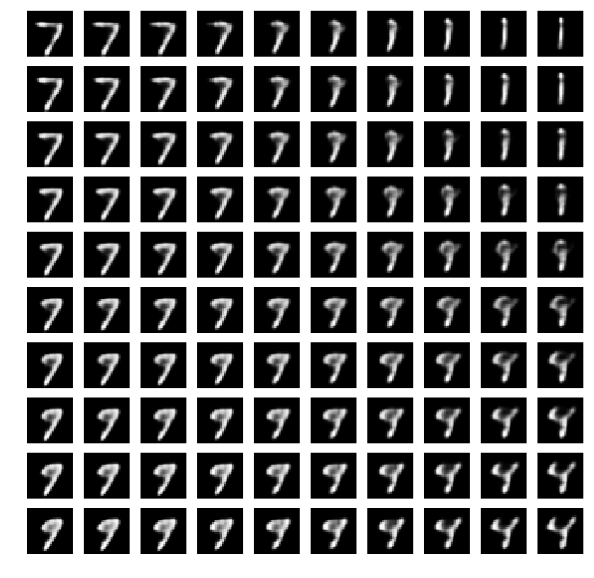

In [43]:
inds = [0, 40, 20, 6]
X = encoder2.predict(testI[inds,:])
Xd = decoder2.predict(Xinterp2(X))
rfig = plt.figure(figsize=(10,10))
show_imgs(Xd.reshape((100,28,28)),nc=10)
plt.close()
rfig

- Traverse the latent space between different 7s
  - captures different shapes of 7

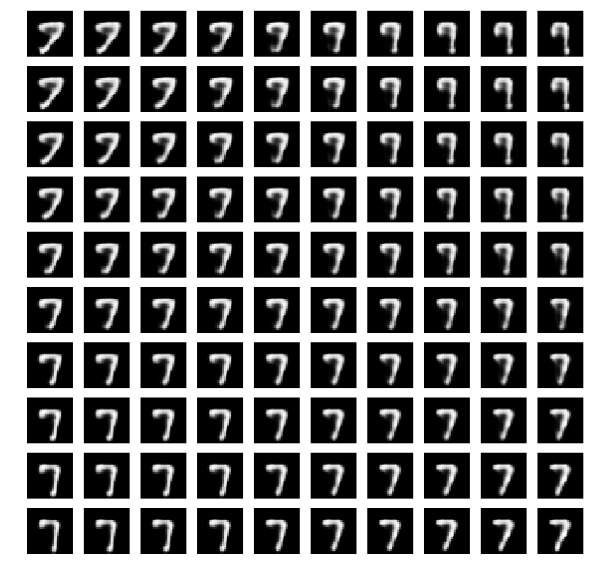

In [44]:
mydigits = where(testY==7)[0]
inds = mydigits[10:14]
X = encoder2.predict(testI[inds,:])
Xd = decoder2.predict(Xinterp2(X))
rfig = plt.figure(figsize=(10,10))
show_imgs(Xd.reshape((100,28,28)),nc=10)
plt.close()
rfig

# Variational AutoEncoder (VAE)
- The standard autoencoder can have difficulty encoding/decoding new images
  - the decoder never sees (encoded) latent vectors outside of the training set
- VAE fixes this by introducing noise in the latent vectors
  - the noise lets the decoder network see slightly different latent vectors for each training image.
  - improves the ability to interpolate between training samples
  
<center><img src="imgs/vae2.png" width=600></center>

In [45]:
# some settings
random.seed(4487); tensorflow.set_random_seed(4487)
original_dim = 784
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

- Build the encoder
- Map the input into the mean and log(sigma) of the Gaussian distribution
  - the mean is the encoded vector

In [46]:
# encoder mapping to distribution (mean and log_sigma)
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# the man and log-sigma
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

- Use the mean and log(sigma) to sample a latent variable z

In [47]:
# sampling function - draw Gaussian random noise
epsilon_std = 0.001
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# layer that samples according to mean and sigma
z = Lambda(sampling)([z_mean, z_log_sigma])


- Decode the latent variable z
- Construct the whole VAE

In [48]:
# create the layers and assign to a variable, since we need 
# to use it later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

# connect the latent variable and hidden states
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end variational autoencoder
vae = Model(x, x_decoded_mean)

- Construxct the generator (decoder)
  - attach another input to the saved layers, and connect them

In [49]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))  # make an input and attach it to the hidden state layer
_h_decoded = decoder_h(decoder_input)       # and other layers
_x_decoded_mean = decoder_mean(_h_decoded)

# the generator model
generator = Model(decoder_input, _x_decoded_mean)

- VAE uses a special loss function
  - minimize the KL divergence between the distributions

In [50]:
# define the VAE loss
def vae_loss(x, x_decoded_mean):
    # cross-entropy loss
    xent_loss = keras.losses.binary_crossentropy(x, x_decoded_mean)
    # KL divergence loss
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

# compile the model for optimization
vae.compile(optimizer='rmsprop', loss=vae_loss)

- The final VAE model
  - note that there are two layers going into lambda_1

In [51]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512)          401920      input_5[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            1026        dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2)            1026        dense_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

- The encoder and decoder

In [52]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 402,946
Trainable params: 402,946
Non-trainable params: 0
_________________________________________________________________


In [53]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


- Fit the model

In [54]:
history = vae.fit(vtrainXraw, vtrainXraw,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(validXraw, validXraw),        
            callbacks=[TensorBoard(log_dir='./logs/vae')],
            verbose=False
           )

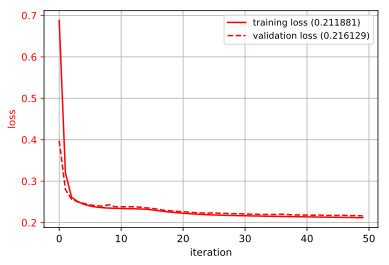

In [55]:
plot_history(history)

- View a scatter plot of the encoded data
  - some digits are located inthe same area

In [56]:
IPython.core.display.set_matplotlib_formats("retina") # switch to png since the next figure is complex

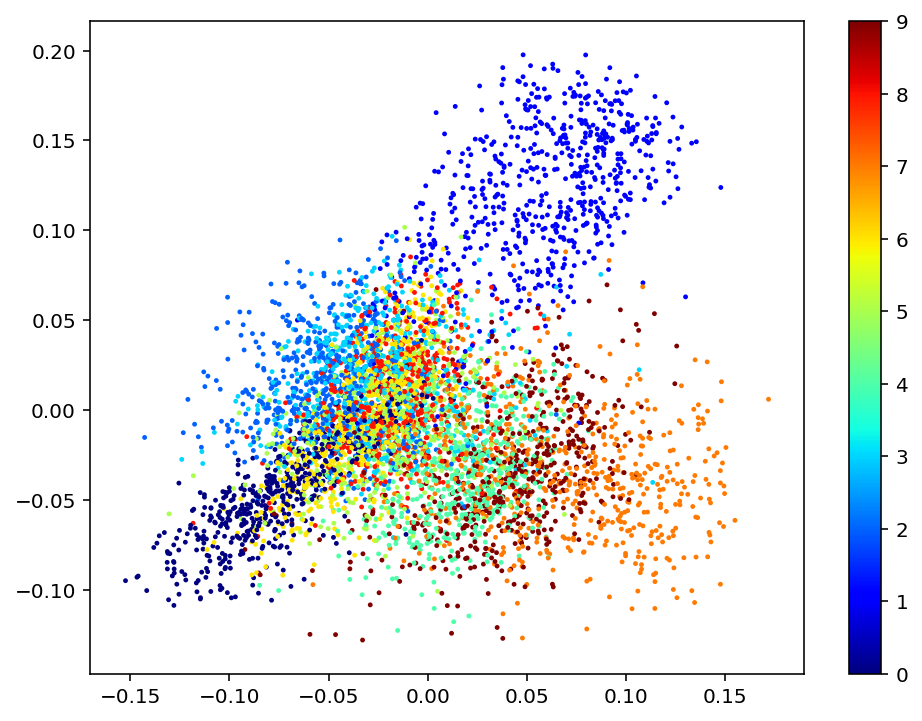

In [57]:
x_test_encoded = encoder.predict(trainXraw)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=trainY, s=2, cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.show()

In [58]:
IPython.core.display.set_matplotlib_formats("svg") # switch to svg

- View some reconstruction results

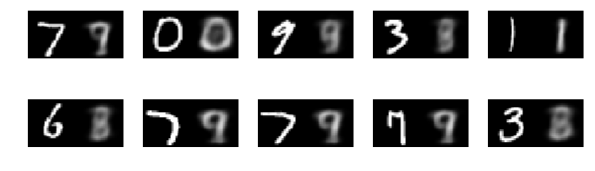

In [59]:
testXrecon = generator.predict(encoder.predict(testXraw))
imglist = []
for j,i in enumerate(range(0,100,10)):
    tmp = hstack( (testXraw[i].reshape((28,28)), testXrecon[i].reshape((28,28))) )
    imglist.append(tmp)
rfig = plt.figure(figsize=(10,3))
show_imgs(imglist,nc=5)
plt.close()
rfig

- visualize the 2D latent space

In [60]:
# select points on a grid from 3 standard deviations around the mean
mn = mean(x_test_encoded, axis=0)
sd = std(x_test_encoded, axis=0)
X = array(
    [ [mn[0]-3*sd[0], mn[1]-3*sd[1]], 
      [mn[0]-3*sd[0], mn[1]+3*sd[1]], 
      [mn[0]+3*sd[0], mn[1]-3*sd[1]], 
      [mn[0]+3*sd[0], mn[1]+3*sd[1]]
    ] )
X.shape

(4, 2)

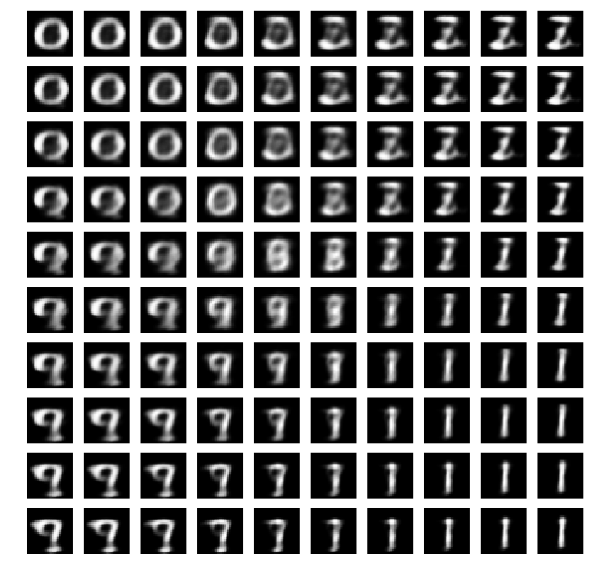

In [61]:
Xd = generator.predict(Xinterp2(X))
rfig = plt.figure(figsize=(10,10))
show_imgs(Xd.reshape((100,28,28)),nc=10)
plt.close()
rfig

# Convolutional VAE
- The previous VAE is using fully-connected layers
- Since the inputs are images, then replace the Dense layers with Conv2D and Pooling
  - The encoder has 3 outputs: the latent mean, log-sigma, and the sampled z
  - Latent dimension is 10

In [62]:
# the Conv2D encoder
latent_dim = 10
input_img2 = Input(shape=(1, 28, 28))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img2)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)

# the mean and log-sigma
z_mean      = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

# sampling step
epsilon_std = 0.01
def sampling(args):
    z_mean, z_log_sigma = args
    #epsilon = K.random_normal(shape=(batch_size, latent_dim))
    epsilon = K.random_normal(shape=K.shape(z_mean), stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

# build the encoder
encoder = Model(input_img2, [z_mean, z_log_sigma, z])

- Encoder summary

In [63]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 28, 28)   160         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 16, 14, 14)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 8, 14, 14)    1160        max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

- Same for the decoder

In [64]:
# the Conv2D decoder
encoded_input2 = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(encoded_input2)
x = Reshape((8,4,4))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input2, x)

In [65]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 4, 4)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 4, 4)           584       
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 8, 16, 16)         0         
__________

- Connect the encoder and decoder
  - select the sampled z of the encoder output

In [66]:
vae = Model(input_img2, decoder(encoder(input_img2)[2]))

In [67]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
model_10 (Model)             [(None, 10), (None, 10),  4484      
_________________________________________________________________
model_11 (Model)             (None, 1, 28, 28)         3889      
Total params: 8,373
Trainable params: 8,373
Non-trainable params: 0
_________________________________________________________________


- The VAE loss as before

In [68]:
def vae_loss(x, x_decoded_mean):
    xent_loss = keras.losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

- Train the model

In [69]:
history = vae.fit(vtrainI, vtrainI,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(validI, validI),        
            callbacks=[earlystop, TensorBoard(log_dir='./logs/vae')],
            verbose=False
           )

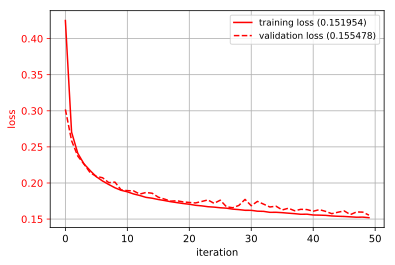

In [70]:
plot_history(history)

- Visualize the 10-dim latent space using t-SNE

In [71]:
IPython.core.display.set_matplotlib_formats("retina") # switch to png since the next figure is complex

In [72]:
x_test_encoded = encoder.predict(trainI)[0]
tsne = manifold.TSNE(n_components=2, perplexity=30.0, random_state=11)
x_test_encoded_2 = tsne.fit_transform(x_test_encoded)

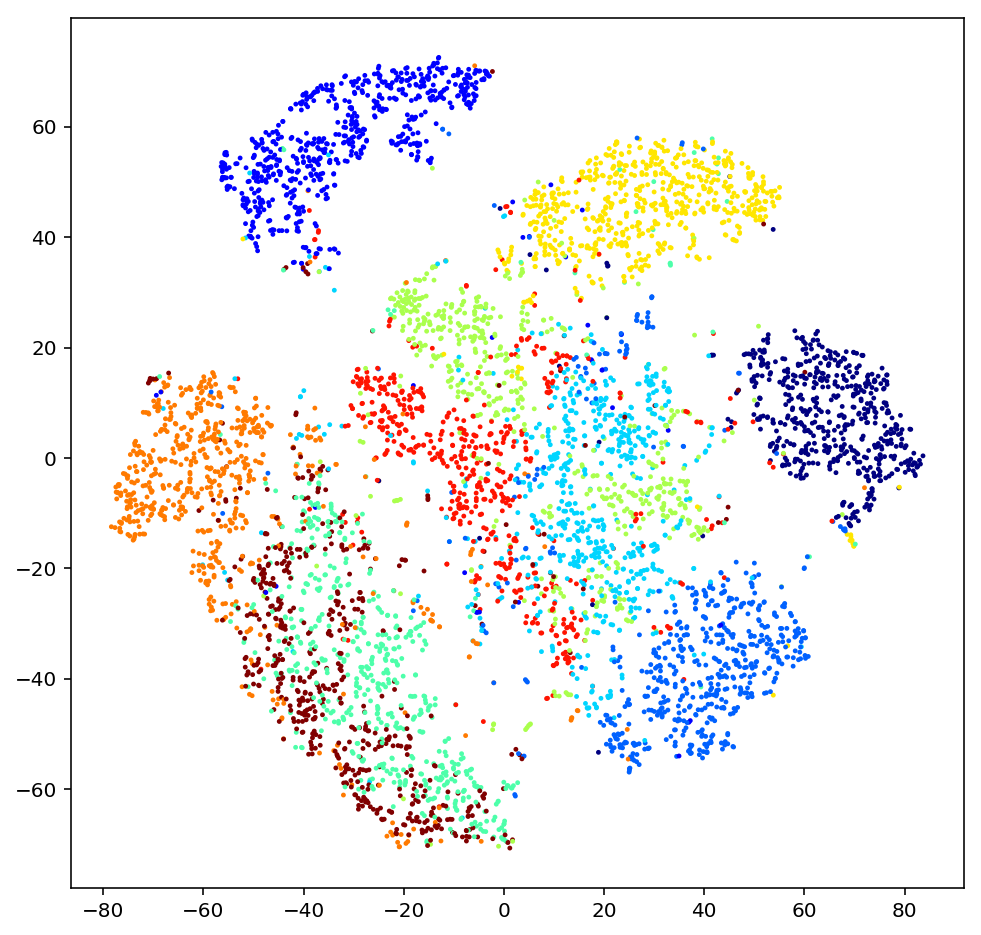

In [73]:
plt.figure(figsize=(8,8))
plt.scatter(x_test_encoded_2[:, 0], x_test_encoded_2[:, 1], c=trainY, s=2, cmap=plt.get_cmap('jet'))

In [74]:
IPython.core.display.set_matplotlib_formats("svg")

- Visualize the reconstruction

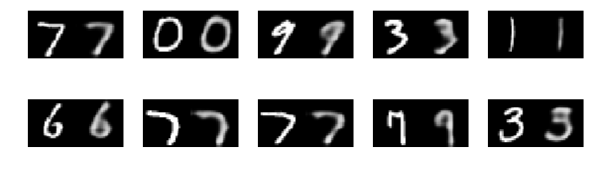

In [75]:
testIrecon = decoder.predict(encoder.predict(testI)[0])
imglist = []
for j,i in enumerate(range(0,100,10)):
    tmp = hstack( (testI[i].reshape((28,28)), testIrecon[i].reshape((28,28))) )
    imglist.append(tmp)
rfig = plt.figure(figsize=(10,3))
show_imgs(imglist,nc=5)
plt.close()
rfig

- Visualize the latent space between a 7, 1, 9, and 4

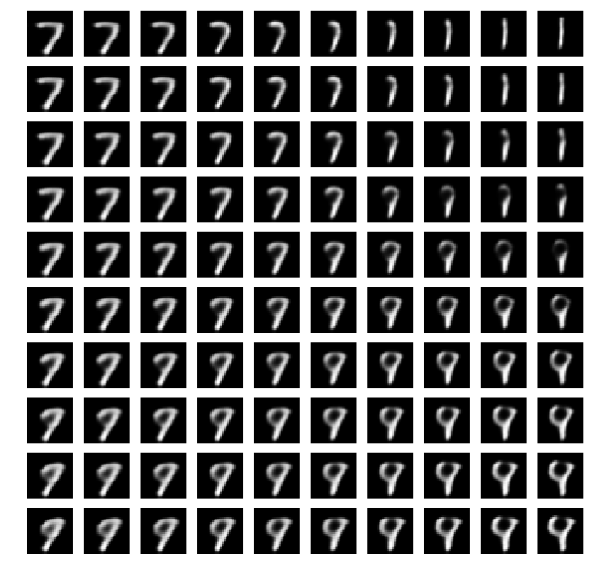

In [76]:
inds = [0, 40, 20, 6]
X = encoder.predict(testI[inds,:])[0]
Xd = decoder.predict(Xinterp2(X))
rfig = plt.figure(figsize=(10,10))
show_imgs(Xd.reshape((100,28,28)),nc=10)
plt.close()
rfig

# Summary
- **Deep architectures**
  - advances of deep learning has been driven by the ImageNet competiton.
  - error rate decreases as the depth increases.
  - as depth increases, need to have a smart architecture design to make training more effective.
- **Unsupervised Learning**
  - Autoencoder - unsupervised dimensionality reduction and clustering.
  - Convolutional autoencoder - AE for images.
  - Variational autoencoder - improve interpolation ability.